# <center>EE6770 Fall 2024 Homework 5: Cats and Dogs Classifier</center>

1. __Write comments__ in the code to explain your thoughts.
2. __Important: Execute the codes and show the results__. 
3. __Do your own work.__ 

### Submission:
 * __Submit this notebook file and the pdf version__ - remember to add your name in the filename.
 * Deadline: 11:59 pm, 10/28 (Monday)

## Assignment Objectives:

### In this assignment, you will develop a CNN model for the cat-and-dog classifer. 
#### You will create `at least two models`, applying the various techniques we discussed for improving the performance. 

1. Deeper Conv layers and/or FC layers
2. Image augmentation
3. Transfer learning
4. Regularization: L1/L2, Batch Normalization, Dropout, Max Norm
5. Increasing image size
6. Increasing size of the train/validation/test dataset

* You will compare the performance of your models with the baseline VGG-5 model that we discussed in class.
* <font color=red>Image size is limited to 128-by-128 or smaller </font>
* <font color=red>Performance requirement: the accuracy on the test data needs to be better than 87.5% for at least one of your models </font>

### Cats & Dogs Dataset

* #### You are given a zip file, `train.zip`, that contains 25,000 labelled images of cats and dogs (12,500 each) 
* #### You will select a subset of $N$ image files from the dataset and store them in the following sub-directory structure, where $N$ can be anywhere between 10,000 to 25,000.
* #### The train-validation-test data split is 60%-15%-25%.
<img src="./images/train_test_dir.png" alt="Drawing" style="width: 250px;"/> 

### Load tool modules

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load CNN models

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout

### Load the image processing tools 

In [14]:
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import image_dataset_from_directory

### Load and Process the dataset
__Create the subdirectory structures per the requirement.__

In [15]:
import os
import shutil

#--------------------------------------#
# Select the number of files to train  #
N = 25000                              #
#--------------------------------------#

source_dir = "./train"
train_dir = "./cats_dogs"

os.makedirs(train_dir, exist_ok=True)

def organize_images(name, start, stop):
    for pet in ("cat", "dog"):
        dir = train_dir + "/" + name + "/" + pet
        os.makedirs(dir, exist_ok=True)

        images = [f"{pet}.{i}.jpg" for i in range(start, stop)]
        for file in images:
            shutil.copy(src=source_dir + '/' + file, dst=dir + '/ '+ file)


N_split = int(25000 / 2)
train_perc = int(N_split * 0.6)
val_percent = train_perc + int(N_split * 0.15)
test_percent = val_percent + int(N_split * 0.25)

organize_images("train", start=0, stop=train_perc)
organize_images("validation", start=train_perc, stop=val_percent)
organize_images("test", start=val_percent, stop=test_percent)

### Display 2 input images: one for dog, and one for cat 

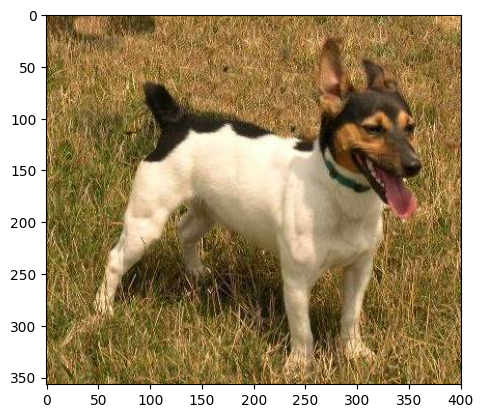

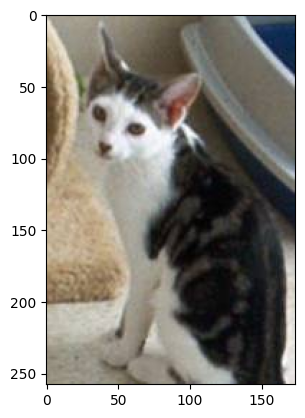

In [16]:
import matplotlib.pyplot as plt
import random


dog_dir = os.listdir(train_dir+'/test'+'/dog')
cat_dir = os.listdir(train_dir+'/test'+'/cat')
dog_sample = random.choice(dog_dir)
cat_sample = random.choice(cat_dir)


dog_img = load_img(os.path.join(train_dir+'/test'+'/dog', dog_sample))
cat_img = load_img(os.path.join(train_dir+'/test'+'/cat', cat_sample))

plt.imshow(dog_img)
plt.show()

plt.imshow(cat_img)
plt.show()

# Baseline CNN Model: VGG-5

In [17]:
# create data generator

# ----------- Target Picture Size ------------ #
target_pic_size = (64, 64)                     #
target_pic_shape = target_pic_size + (3,)      #
# -------------------------------------------- #


train_data = image_dataset_from_directory(train_dir + '/train',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)

val_data = image_dataset_from_directory(train_dir + '/validation',
           color_mode='rgb', batch_size=64, image_size=target_pic_size)

test_data = image_dataset_from_directory(train_dir + '/test',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)


    
model = Sequential()

# Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=target_pic_shape))
model.add(MaxPooling2D((2, 2)))

# Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

# FC Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.summary()





Found 15000 files belonging to 2 classes.
Found 3750 files belonging to 2 classes.
Found 6250 files belonging to 2 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(train_data, epochs=10, batch_size=64, validation_data=val_data, verbose=1)


Epoch 1/10


I0000 00:00:1729861517.619494   34352 service.cc:146] XLA service 0x7f9040019270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729861517.619543   34352 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-10-25 09:05:17.668246: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-25 09:05:17.811187: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 13/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5055 - loss: 16.8828

I0000 00:00:1729861521.321174   34352 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.5573 - loss: 2.9802 - val_accuracy: 0.6995 - val_loss: 0.5839
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6973 - loss: 0.5793 - val_accuracy: 0.7411 - val_loss: 0.5265
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7568 - loss: 0.5078 - val_accuracy: 0.7296 - val_loss: 0.5544
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7823 - loss: 0.4672 - val_accuracy: 0.7683 - val_loss: 0.5086
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8055 - loss: 0.4242 - val_accuracy: 0.7736 - val_loss: 0.5016
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8278 - loss: 0.3885 - val_accuracy: 0.7763 - val_loss: 0.5514
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8589 - loss: 0.3268 - val_accuracy: 0.7845 - val_loss: 0.5686
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8728 - loss: 0.2877 - val_accuracy: 0.78

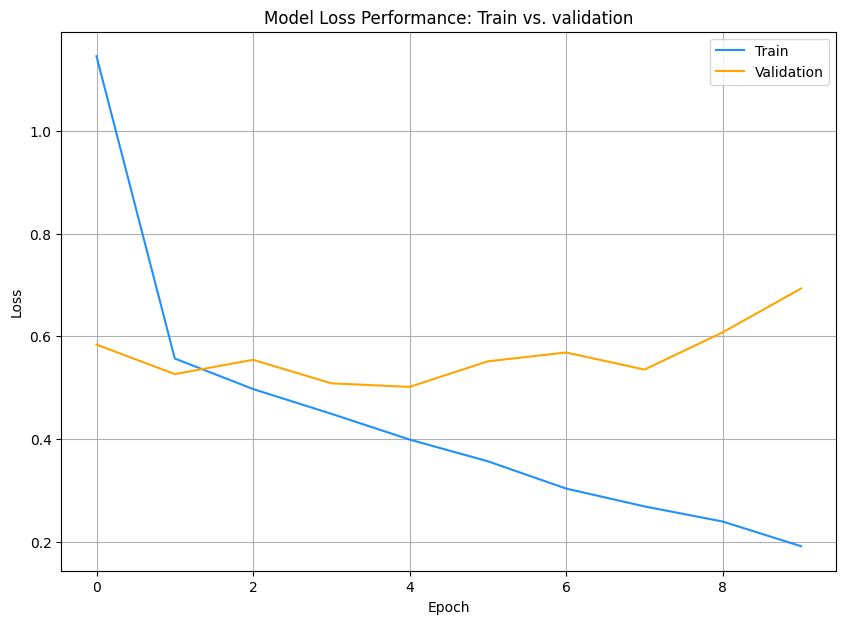

In [19]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

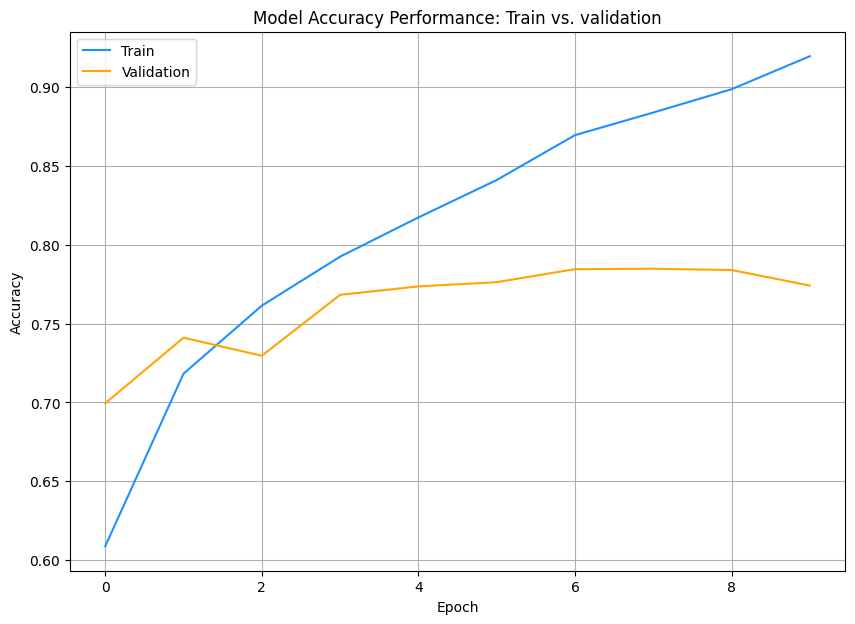

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7799 - loss: 0.6839
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [20]:
accu = history.history['accuracy']  # Loss data for Training 
accu_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Accuracy Performance: Train vs. validation')
plt.plot(accu, color='DodgerBlue', label='Train')
plt.plot(accu_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

loss, accuracy = model.evaluate(test_data, verbose=1)

y_pred = model.predict(test_data)

# <font color=blue>Build CNN Model One</font>

## <font color=green>Define the CNN model</font> 

__Use CONV, POOL and FC layers to construct your CNN model. You can also load pre-trained model, if transfer learning is used. You will train and test the model after this step.__

In [21]:
# ----------- Target Picture Size ------------ #
target_pic_size = (128, 128)                     #
target_pic_shape = target_pic_size + (3,)      #
# -------------------------------------------- #

train_data = image_dataset_from_directory(train_dir + '/train',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)

val_data = image_dataset_from_directory(train_dir + '/validation',
           color_mode='rgb', batch_size=64, image_size=target_pic_size)

test_data = image_dataset_from_directory(train_dir + '/test',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)


cnn1 = Sequential()

# Layer 1
cnn1.add(Conv2D(32, (3, 3), activation='relu', input_shape=target_pic_shape))
cnn1.add(Conv2D(32, (3, 3), activation='relu',))
cnn1.add(MaxPooling2D((2, 2)))

# Layer 2
cnn1.add(Conv2D(64, (3, 3), activation='relu'))
cnn1.add(Conv2D(64, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2, 2)))

# Layer 3
cnn1.add(Conv2D(128, (3, 3), activation='relu'))
cnn1.add(Conv2D(128, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2, 2)))

# Layer 4
cnn1.add(Conv2D(256, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2, 2)))

# Layer 5
cnn1.add(Conv2D(512, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2, 2)))

cnn1.add(Flatten())

# FC Layers
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(1, activation='sigmoid'))


Found 15000 files belonging to 2 classes.
Found 3750 files belonging to 2 classes.
Found 6250 files belonging to 2 classes.


### Print the model summary that shows the output shape and # of parameters for each layer.

In [22]:
cnn1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,126,337 (4.30 MB)

 Trainable params: 1,126,337 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

### <font color=red>Question: What are the total number of parameters for the model?</font>

<font color = blue>**Answer:** This model has 1,126,337 parameters and takes up 4.30 MB</font>

## <font color=green>Train the CNN Model</font>

__Note: Display the history when running model.fit( )__

In [23]:
cnn1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn1.fit(train_data, epochs=10, batch_size=64, validation_data=val_data, verbose=1)

Epoch 1/10


2024-10-25 09:06:00.404548: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_989', 436 bytes spill stores, 436 bytes spill loads



235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.5706 - loss: 2.1737 - val_accuracy: 0.7339 - val_loss: 0.5470
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7216 - loss: 0.5477 - val_accuracy: 0.7427 - val_loss: 0.5059
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7850 - loss: 0.4564 - val_accuracy: 0.8163 - val_loss: 0.4124
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.8244 - loss: 0.3924 - val_accuracy: 0.8248 - val_loss: 0.3943
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.8566 - loss: 0.3298 - val_accuracy: 0.8397 - val_loss: 0.3591
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.8901 - loss: 0.2595 - val_accuracy: 0.8544 - val_loss: 0.3353
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9083 - loss: 0.2192 - val_accuracy: 0.8600 - val_loss: 0.3761
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9201 - loss: 0.1875 - val_accuracy: 0.86

### <font color=red>Question: What is the estimated total model training time?</font>

<font color=blue>**Answer:** With the CPU/GPU combination I have it takes about6 minutes to run</font>

### Compare Loss and Accuracy Performance for train and validation data

#### Plot the loss data, for both train and validation data

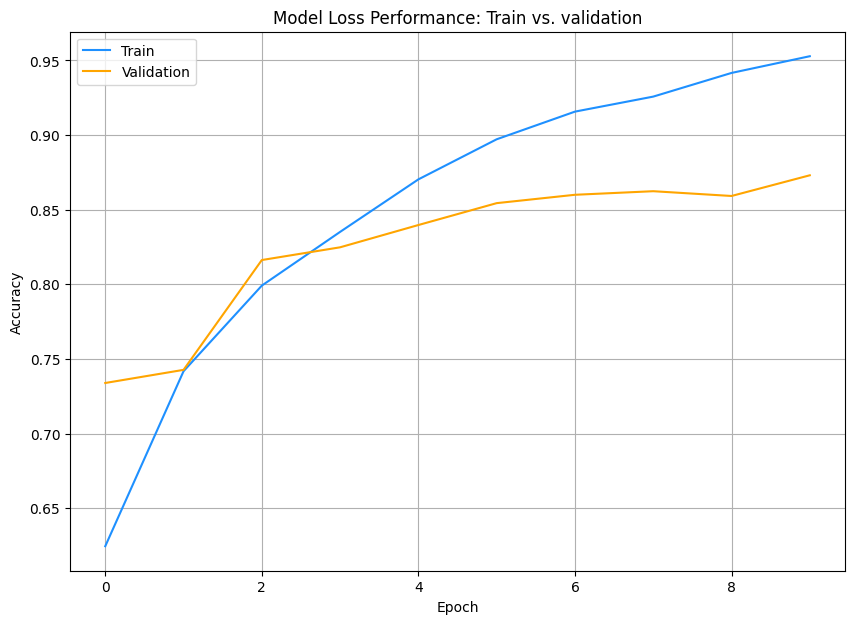

In [24]:
J = history.history['accuracy']  # Loss data for Training 
J_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

#### Plot the accuracy data, for both train and validation data

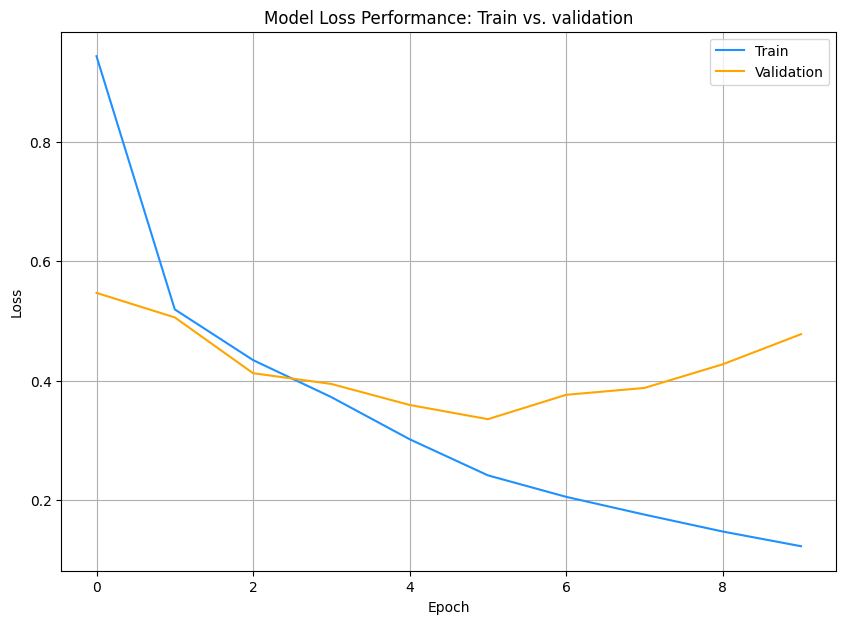

In [25]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

## <font color=green>Test the CNN Model</font>
__Note: Display the history when running model.evaluate( )__

### <font color=red>Question: What is the estimated inference (testing) time on test dataset?</font>

<font color = blue>**Answer:** It took 14 seconds to run the inference</font>

### Print the final loss and accuracy of the test data

In [26]:
loss, accuracy = cnn1.evaluate(test_data, verbose=1)

y_pred = cnn1.predict(test_data)

print("Accuracy: ", round(accuracy * 100, 2), "%")
print("Loss: ", round(loss, 2))

98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8719 - loss: 0.5069
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Accuracy:  86.7 %
Loss:  0.53


### Save the CNN model parameters

In [27]:
cnn1.save('./cnn1.keras')

# <font color=blue>Build CNN Model Two</font>

__For your second and subsequent models, follow the same set of instructions provided for Model One__

In [28]:
# ----------- Target Picture Size ------------ #
target_pic_size = (128, 128)                     #
target_pic_shape = target_pic_size + (3,)      #
# -------------------------------------------- #

train_data = image_dataset_from_directory(train_dir + '/train',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)

val_data = image_dataset_from_directory(train_dir + '/validation',
           color_mode='rgb', batch_size=64, image_size=target_pic_size)

test_data = image_dataset_from_directory(train_dir + '/test',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)



cnn2 = Sequential()

cnn2.add(Conv2D(16, (3,3), activation= 'relu', input_shape = target_pic_shape))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Conv2D(32, (3,3), activation= 'relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Conv2D(64, (3,3), activation= 'relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Conv2D(128, (3,3), activation= 'relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Conv2D(256, (3,3), activation= 'relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Flatten())

cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dense(1, activation='sigmoid'))

Found 15000 files belonging to 2 classes.
Found 3750 files belonging to 2 classes.
Found 6250 files belonging to 2 classes.


In [29]:
cnn2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 508032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │    65,028,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,031,937 (248.08 MB)

 Trainable params: 65,031,937 (248.08 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
cnn2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn2.fit(train_data, epochs=10, batch_size=64, validation_data=val_data, verbose=1)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.5544 - loss: 654.2979 - val_accuracy: 0.6376 - val_loss: 1.3510
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.7595 - loss: 0.6713 - val_accuracy: 0.6573 - val_loss: 1.1055
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.8900 - loss: 0.2881 - val_accuracy: 0.6779 - val_loss: 1.1254
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.9478 - loss: 0.1728 - val_accuracy: 0.6832 - val_loss: 1.2476
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.9756 - loss: 0.1029 - val_accuracy: 0.6808 - val_loss: 1.3733
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.9868 - loss: 0.0693 - val_accuracy: 0.6829 - val_loss: 1.4760
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.9860 - loss: 0.0761 - val_accuracy: 0.6645 - val_loss: 1.9494
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.9594 - loss: 0.1499 

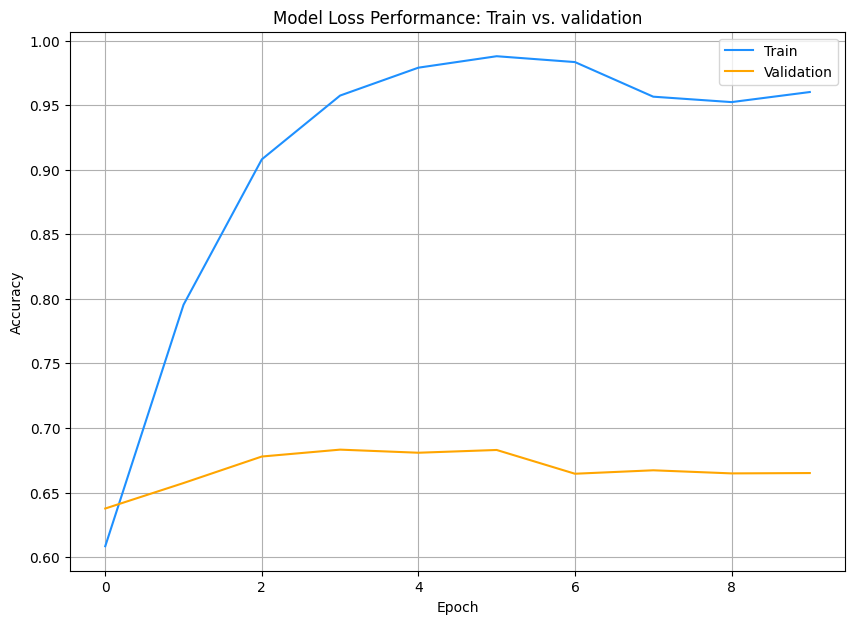

In [31]:
J = history.history['accuracy']  # Loss data for Training 
J_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

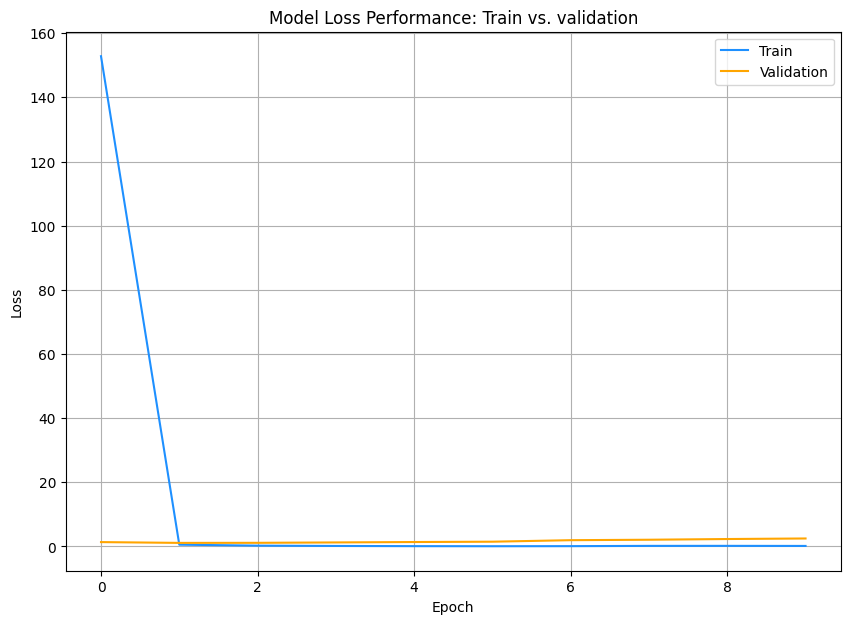

In [32]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

In [33]:
loss, accuracy = cnn2.evaluate(test_data, verbose=1)

y_pred = cnn2.predict(test_data)

print("Accuracy: ", round(accuracy * 100, 2), "%")
print("Loss: ", round(loss, 2))

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6715 - loss: 2.2373
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Accuracy:  66.48 %
Loss:  2.33


In [ ]:
cnn2.save('./cnn2.keras')

## <font color=green>Conclusion</font>

### You will fill out information in this table:
| Model              | Accuracy | Number of Parameters | Training Time | Inference Speed |
|-------------------- |----------|-----------------------|--------------- |------------------|
| Baseline VGG-5     |          |                       |                |                  |
| CNN1           |          |                       |                |                  |
| CNN2          |          |                       |                |                  |
| Model Three         |          |                       |                |                  |


__Please add comments on what you tried and observed while working on the assignment.__

## <center><font color=maroon>Remember to turn in both the notebook and the pdf version.</font></center>